In [ ]:
import os

import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "path name/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))


In [ ]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [ ]:
asteroids_X = asteroids_X - np.min(asteroids_X, axis=1).reshape(-1, 1)
asteroids_X /= np.max(asteroids_X, axis=1).reshape(-1, 1)

In [ ]:
asteroids_X = np.expand_dims(asteroids_X, axis=2)

In [ ]:
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [ ]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    norm_layer = normalizer(input_layer)

    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3)(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Conv1D(filters=64,
                                       activation="relu",
                                       kernel_size=5)(hidden_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Flatten()(hidden_layer)
    hidden_layer = keras.layers.Dense(16, activation="relu")(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 normalization (Normalizati  (None, 49, 1)             99        
 on)                                                             
                                                                 
 conv1d (Conv1D)             (None, 47, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 64)             0     

In [ ]:
end_epoch = 400
batch_size = 64

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    sample_weight=sample_weight)

Epoch 1/400
12/13 [==========================>...] - ETA: 0s - loss: 0.7344

13/13 [==============================] - 1s 33ms/step - loss: 0.7342 - val_loss: 0.6095
Epoch 2/400
13/13 [==============================] - ETA: 0s - loss: 0.5525

13/13 [==============================] - 0s 13ms/step - loss: 0.5525 - val_loss: 0.5193
Epoch 3/400
 8/13 [=================>............] - ETA: 0s - loss: 0.4747

13/13 [==============================] - 0s 12ms/step - loss: 0.4748 - val_loss: 0.4948
Epoch 4/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.4328

13/13 [==============================] - 0s 13ms/step - loss: 0.4073 - val_loss: 0.4627
Epoch 5/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.3540

13/13 [==============================] - 0s 12ms/step - loss: 0.3731 - val_loss: 0.4449
Epoch 6/400
12/13 [==========================>...] - ETA: 0s - loss: 0.3502

13/13 [==============================] - 0s 13ms/step - loss: 0.3521 - val_loss: 0.5136
Epoch 7/400
13/13 [==============================] - ETA: 0s - loss: 0.3180

13/13 [==============================] - 0s 13ms/step - loss: 0.3180 - val_loss: 0.4434
Epoch 8/400
13/13 [==============================] - ETA: 0s - loss: 0.2975

13/13 [==============================] - 0s 13ms/step - loss: 0.2975 - val_loss: 0.4767
Epoch 9/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2739

13/13 [==============================] - 0s 12ms/step - loss: 0.2884 - val_loss: 0.4635
Epoch 10/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2500

13/13 [==============================] - 0s 12ms/step - loss: 0.2715 - val_loss: 0.4851
Epoch 11/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2680

13/13 [==============================] - 0s 12ms/step - loss: 0.2649 - val_loss: 0.4972
Epoch 12/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2769

13/13 [==============================] - 0s 12ms/step - loss: 0.2715 - val_loss: 0.5064
Epoch 13/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2530

13/13 [==============================] - 0s 12ms/step - loss: 0.2580 - val_loss: 0.4912
Epoch 14/400
13/13 [==============================] - ETA: 0s - loss: 0.2743

13/13 [==============================] - 0s 13ms/step - loss: 0.2743 - val_loss: 0.5588
Epoch 15/400
13/13 [==============================] - ETA: 0s - loss: 0.2540

13/13 [==============================] - 0s 14ms/step - loss: 0.2540 - val_loss: 0.4471
Epoch 16/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2210

13/13 [==============================] - 0s 13ms/step - loss: 0.2318 - val_loss: 0.4883
Epoch 17/400
13/13 [==============================] - ETA: 0s - loss: 0.2345

13/13 [==============================] - 0s 13ms/step - loss: 0.2345 - val_loss: 0.4345
Epoch 18/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2161

13/13 [==============================] - 0s 12ms/step - loss: 0.2327 - val_loss: 0.4580
Epoch 19/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2008

13/13 [==============================] - 0s 11ms/step - loss: 0.2355 - val_loss: 0.4819
Epoch 20/400
11/13 [========================>.....] - ETA: 0s - loss: 0.2271

13/13 [==============================] - 0s 14ms/step - loss: 0.2240 - val_loss: 0.4166
Epoch 21/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1971

13/13 [==============================] - 0s 12ms/step - loss: 0.2162 - val_loss: 0.4512
Epoch 22/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2105

13/13 [==============================] - 0s 12ms/step - loss: 0.2095 - val_loss: 0.4729
Epoch 23/400
13/13 [==============================] - ETA: 0s - loss: 0.2154

13/13 [==============================] - 0s 13ms/step - loss: 0.2154 - val_loss: 0.4725
Epoch 24/400
13/13 [==============================] - ETA: 0s - loss: 0.2200

13/13 [==============================] - 0s 13ms/step - loss: 0.2200 - val_loss: 0.4339
Epoch 25/400
11/13 [========================>.....] - ETA: 0s - loss: 0.2089

13/13 [==============================] - 0s 14ms/step - loss: 0.2072 - val_loss: 0.4367
Epoch 26/400
13/13 [==============================] - ETA: 0s - loss: 0.1924

13/13 [==============================] - 0s 13ms/step - loss: 0.1924 - val_loss: 0.4608
Epoch 27/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2257

13/13 [==============================] - 0s 12ms/step - loss: 0.2070 - val_loss: 0.4922
Epoch 28/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1864

13/13 [==============================] - 0s 12ms/step - loss: 0.2012 - val_loss: 0.4065
Epoch 29/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2123

13/13 [==============================] - 0s 12ms/step - loss: 0.2027 - val_loss: 0.4362
Epoch 30/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2059

13/13 [==============================] - 0s 12ms/step - loss: 0.1975 - val_loss: 0.4226
Epoch 31/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1709

13/13 [==============================] - 0s 11ms/step - loss: 0.1891 - val_loss: 0.4414
Epoch 32/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1863

13/13 [==============================] - 0s 13ms/step - loss: 0.1874 - val_loss: 0.4224
Epoch 33/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1929

13/13 [==============================] - 0s 12ms/step - loss: 0.1944 - val_loss: 0.4532
Epoch 34/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1778

13/13 [==============================] - 0s 13ms/step - loss: 0.1789 - val_loss: 0.3977
Epoch 35/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2023

13/13 [==============================] - 0s 12ms/step - loss: 0.1876 - val_loss: 0.3991
Epoch 36/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2002

13/13 [==============================] - 0s 11ms/step - loss: 0.1841 - val_loss: 0.3731
Epoch 37/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1682

13/13 [==============================] - 0s 12ms/step - loss: 0.1675 - val_loss: 0.4115
Epoch 38/400
10/13 [======================>.......] - ETA: 0s - loss: 0.1724

13/13 [==============================] - 0s 20ms/step - loss: 0.1715 - val_loss: 0.3639
Epoch 39/400
13/13 [==============================] - ETA: 0s - loss: 0.1672

13/13 [==============================] - 0s 21ms/step - loss: 0.1672 - val_loss: 0.4136
Epoch 40/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.1742

13/13 [==============================] - 0s 19ms/step - loss: 0.1630 - val_loss: 0.3715
Epoch 41/400
10/13 [======================>.......] - ETA: 0s - loss: 0.1524

13/13 [==============================] - 0s 22ms/step - loss: 0.1645 - val_loss: 0.3954
Epoch 42/400
12/13 [==========================>...] - ETA: 0s - loss: 0.1711

13/13 [==============================] - 0s 20ms/step - loss: 0.1695 - val_loss: 0.3733
Epoch 43/400
13/13 [==============================] - ETA: 0s - loss: 0.1622

13/13 [==============================] - 0s 22ms/step - loss: 0.1622 - val_loss: 0.3799
Epoch 44/400
13/13 [==============================] - ETA: 0s - loss: 0.1541

13/13 [==============================] - 0s 25ms/step - loss: 0.1541 - val_loss: 0.3764
Epoch 45/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.1745

13/13 [==============================] - 0s 22ms/step - loss: 0.1643 - val_loss: 0.3763
Epoch 46/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.1482

13/13 [==============================] - 0s 19ms/step - loss: 0.1472 - val_loss: 0.3924
Epoch 47/400
10/13 [======================>.......] - ETA: 0s - loss: 0.1507

13/13 [==============================] - 0s 18ms/step - loss: 0.1513 - val_loss: 0.3676
Epoch 48/400
13/13 [==============================] - ETA: 0s - loss: 0.1468

13/13 [==============================] - 0s 20ms/step - loss: 0.1468 - val_loss: 0.4208
Epoch 49/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.1331

13/13 [==============================] - 0s 21ms/step - loss: 0.1406 - val_loss: 0.3704
Epoch 50/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.1477

13/13 [==============================] - 0s 21ms/step - loss: 0.1439 - val_loss: 0.3971
Epoch 51/400
13/13 [==============================] - ETA: 0s - loss: 0.1526

13/13 [==============================] - 0s 22ms/step - loss: 0.1526 - val_loss: 0.3889
Epoch 52/400
13/13 [==============================] - ETA: 0s - loss: 0.1593

13/13 [==============================] - 0s 19ms/step - loss: 0.1593 - val_loss: 0.3801
Epoch 53/400
10/13 [======================>.......] - ETA: 0s - loss: 0.1364

13/13 [==============================] - 0s 19ms/step - loss: 0.1402 - val_loss: 0.3787
Epoch 54/400
13/13 [==============================] - ETA: 0s - loss: 0.1332

13/13 [==============================] - 0s 19ms/step - loss: 0.1332 - val_loss: 0.3573
Epoch 55/400
13/13 [==============================] - ETA: 0s - loss: 0.1311

13/13 [==============================] - 0s 13ms/step - loss: 0.1311 - val_loss: 0.3976
Epoch 56/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1280

13/13 [==============================] - 0s 12ms/step - loss: 0.1290 - val_loss: 0.3691
Epoch 57/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1436

13/13 [==============================] - 0s 12ms/step - loss: 0.1245 - val_loss: 0.3998
Epoch 58/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1222

13/13 [==============================] - 0s 12ms/step - loss: 0.1270 - val_loss: 0.3744
Epoch 59/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1454

13/13 [==============================] - 0s 13ms/step - loss: 0.1255 - val_loss: 0.3703
Epoch 60/400
12/13 [==========================>...] - ETA: 0s - loss: 0.1254

13/13 [==============================] - 0s 13ms/step - loss: 0.1241 - val_loss: 0.3766
Epoch 61/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1059

13/13 [==============================] - 0s 13ms/step - loss: 0.1241 - val_loss: 0.3940
Epoch 62/400
13/13 [==============================] - ETA: 0s - loss: 0.1264

13/13 [==============================] - 0s 14ms/step - loss: 0.1264 - val_loss: 0.3591
Epoch 63/400
13/13 [==============================] - ETA: 0s - loss: 0.1189

13/13 [==============================] - 0s 14ms/step - loss: 0.1189 - val_loss: 0.3586
Epoch 64/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1003

13/13 [==============================] - 0s 13ms/step - loss: 0.1184 - val_loss: 0.3891
Epoch 65/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1097

13/13 [==============================] - 0s 13ms/step - loss: 0.1182 - val_loss: 0.3945
Epoch 66/400
12/13 [==========================>...] - ETA: 0s - loss: 0.1167

13/13 [==============================] - 0s 14ms/step - loss: 0.1154 - val_loss: 0.4021
Epoch 67/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0930

13/13 [==============================] - 0s 12ms/step - loss: 0.1155 - val_loss: 0.3496
Epoch 68/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1206

13/13 [==============================] - 0s 12ms/step - loss: 0.1217 - val_loss: 0.4086
Epoch 69/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1152

13/13 [==============================] - 0s 11ms/step - loss: 0.1198 - val_loss: 0.4118
Epoch 70/400
13/13 [==============================] - ETA: 0s - loss: 0.1163

13/13 [==============================] - 0s 13ms/step - loss: 0.1163 - val_loss: 0.3779
Epoch 71/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0993

13/13 [==============================] - 0s 13ms/step - loss: 0.1043 - val_loss: 0.4093
Epoch 72/400
12/13 [==========================>...] - ETA: 0s - loss: 0.1029

13/13 [==============================] - 0s 14ms/step - loss: 0.1035 - val_loss: 0.3822
Epoch 73/400
13/13 [==============================] - ETA: 0s - loss: 0.1175

13/13 [==============================] - 0s 13ms/step - loss: 0.1175 - val_loss: 0.4091
Epoch 74/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1219

13/13 [==============================] - 0s 13ms/step - loss: 0.1089 - val_loss: 0.4145
Epoch 75/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1020

13/13 [==============================] - 0s 12ms/step - loss: 0.1072 - val_loss: 0.3764
Epoch 76/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1028

13/13 [==============================] - 0s 13ms/step - loss: 0.1014 - val_loss: 0.4869
Epoch 77/400
12/13 [==========================>...] - ETA: 0s - loss: 0.1122

13/13 [==============================] - 0s 14ms/step - loss: 0.1121 - val_loss: 0.3980
Epoch 78/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1145

13/13 [==============================] - 0s 12ms/step - loss: 0.1066 - val_loss: 0.4279
Epoch 79/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0942

13/13 [==============================] - 0s 11ms/step - loss: 0.1015 - val_loss: 0.4311
Epoch 80/400
13/13 [==============================] - ETA: 0s - loss: 0.0988

13/13 [==============================] - 0s 13ms/step - loss: 0.0988 - val_loss: 0.3550
Epoch 81/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.1086

13/13 [==============================] - 0s 12ms/step - loss: 0.0991 - val_loss: 0.4569
Epoch 82/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0910

13/13 [==============================] - 0s 12ms/step - loss: 0.0927 - val_loss: 0.4063
Epoch 83/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1017

13/13 [==============================] - 0s 12ms/step - loss: 0.0972 - val_loss: 0.3715
Epoch 84/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0973

13/13 [==============================] - 0s 15ms/step - loss: 0.0961 - val_loss: 0.4628
Epoch 85/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0891

13/13 [==============================] - 0s 12ms/step - loss: 0.0940 - val_loss: 0.4202
Epoch 86/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0891

13/13 [==============================] - 0s 12ms/step - loss: 0.0984 - val_loss: 0.4366
Epoch 87/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0831

13/13 [==============================] - 0s 12ms/step - loss: 0.0914 - val_loss: 0.4528
Epoch 88/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0739

13/13 [==============================] - 0s 12ms/step - loss: 0.0958 - val_loss: 0.3937
Epoch 89/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0948

13/13 [==============================] - 0s 12ms/step - loss: 0.0974 - val_loss: 0.4666
Epoch 90/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0958

13/13 [==============================] - 0s 14ms/step - loss: 0.0977 - val_loss: 0.3902
Epoch 91/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0905

13/13 [==============================] - 0s 12ms/step - loss: 0.0903 - val_loss: 0.4417
Epoch 92/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1075

13/13 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.4719
Epoch 93/400
13/13 [==============================] - ETA: 0s - loss: 0.0861

13/13 [==============================] - 0s 13ms/step - loss: 0.0861 - val_loss: 0.4133
Epoch 94/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0875

13/13 [==============================] - 0s 13ms/step - loss: 0.0834 - val_loss: 0.4194
Epoch 95/400
13/13 [==============================] - ETA: 0s - loss: 0.0821

13/13 [==============================] - 0s 13ms/step - loss: 0.0821 - val_loss: 0.4312
Epoch 96/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0835

13/13 [==============================] - 0s 14ms/step - loss: 0.0844 - val_loss: 0.5033
Epoch 97/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0809

13/13 [==============================] - 0s 12ms/step - loss: 0.0940 - val_loss: 0.4143
Epoch 98/400
13/13 [==============================] - ETA: 0s - loss: 0.0791

13/13 [==============================] - 0s 13ms/step - loss: 0.0791 - val_loss: 0.4793
Epoch 99/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0724

13/13 [==============================] - 0s 16ms/step - loss: 0.0817 - val_loss: 0.4508
Epoch 100/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0694

13/13 [==============================] - 0s 12ms/step - loss: 0.0841 - val_loss: 0.4618
Epoch 101/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0829

13/13 [==============================] - 0s 13ms/step - loss: 0.0847 - val_loss: 0.4965
Epoch 102/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0895

13/13 [==============================] - 0s 14ms/step - loss: 0.0929 - val_loss: 0.4748
Epoch 103/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0808

13/13 [==============================] - 0s 14ms/step - loss: 0.0821 - val_loss: 0.4273
Epoch 104/400
13/13 [==============================] - ETA: 0s - loss: 0.0955

13/13 [==============================] - 0s 13ms/step - loss: 0.0955 - val_loss: 0.5224
Epoch 105/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0805

13/13 [==============================] - 0s 13ms/step - loss: 0.0815 - val_loss: 0.4761
Epoch 106/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0707

13/13 [==============================] - 0s 13ms/step - loss: 0.0715 - val_loss: 0.4992
Epoch 107/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0769

13/13 [==============================] - 0s 17ms/step - loss: 0.0748 - val_loss: 0.5198
Epoch 108/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0811

13/13 [==============================] - 0s 12ms/step - loss: 0.0782 - val_loss: 0.4731
Epoch 109/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0778

13/13 [==============================] - 0s 12ms/step - loss: 0.0734 - val_loss: 0.5349
Epoch 110/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0692

13/13 [==============================] - 0s 13ms/step - loss: 0.0710 - val_loss: 0.4462
Epoch 111/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0761

13/13 [==============================] - 0s 12ms/step - loss: 0.0733 - val_loss: 0.5181
Epoch 112/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0657

13/13 [==============================] - 0s 17ms/step - loss: 0.0677 - val_loss: 0.4635
Epoch 113/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0619

13/13 [==============================] - 0s 21ms/step - loss: 0.0688 - val_loss: 0.4709
Epoch 114/400
13/13 [==============================] - ETA: 0s - loss: 0.0733

13/13 [==============================] - 0s 23ms/step - loss: 0.0733 - val_loss: 0.5336
Epoch 115/400
13/13 [==============================] - ETA: 0s - loss: 0.0724

13/13 [==============================] - 0s 19ms/step - loss: 0.0724 - val_loss: 0.5319
Epoch 116/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0714

13/13 [==============================] - 0s 17ms/step - loss: 0.0687 - val_loss: 0.4476
Epoch 117/400
13/13 [==============================] - ETA: 0s - loss: 0.0693

13/13 [==============================] - 0s 23ms/step - loss: 0.0693 - val_loss: 0.4909
Epoch 118/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0762

13/13 [==============================] - 0s 23ms/step - loss: 0.0691 - val_loss: 0.5191
Epoch 119/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0717

13/13 [==============================] - 0s 21ms/step - loss: 0.0729 - val_loss: 0.4640
Epoch 120/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0879

13/13 [==============================] - 0s 18ms/step - loss: 0.0856 - val_loss: 0.5125
Epoch 121/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0634

13/13 [==============================] - 0s 21ms/step - loss: 0.0687 - val_loss: 0.4961
Epoch 122/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0631

13/13 [==============================] - 0s 22ms/step - loss: 0.0634 - val_loss: 0.4936
Epoch 123/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0587

13/13 [==============================] - 0s 20ms/step - loss: 0.0630 - val_loss: 0.4898
Epoch 124/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0662

13/13 [==============================] - 0s 22ms/step - loss: 0.0680 - val_loss: 0.5202
Epoch 125/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0737

13/13 [==============================] - 0s 22ms/step - loss: 0.0748 - val_loss: 0.5649
Epoch 126/400
13/13 [==============================] - ETA: 0s - loss: 0.0685

13/13 [==============================] - 0s 20ms/step - loss: 0.0685 - val_loss: 0.5136
Epoch 127/400
13/13 [==============================] - ETA: 0s - loss: 0.0702

13/13 [==============================] - 0s 20ms/step - loss: 0.0702 - val_loss: 0.4989
Epoch 128/400
13/13 [==============================] - ETA: 0s - loss: 0.0720

13/13 [==============================] - 0s 22ms/step - loss: 0.0720 - val_loss: 0.5694
Epoch 129/400
13/13 [==============================] - ETA: 0s - loss: 0.0618

13/13 [==============================] - 0s 19ms/step - loss: 0.0618 - val_loss: 0.5474
Epoch 130/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0544

13/13 [==============================] - 0s 16ms/step - loss: 0.0587 - val_loss: 0.5506
Epoch 131/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0699

13/13 [==============================] - 0s 12ms/step - loss: 0.0581 - val_loss: 0.5622
Epoch 132/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0604

13/13 [==============================] - 0s 12ms/step - loss: 0.0612 - val_loss: 0.5656
Epoch 133/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0613

13/13 [==============================] - 0s 12ms/step - loss: 0.0561 - val_loss: 0.5476
Epoch 134/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0633

13/13 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.5469
Epoch 135/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0599

13/13 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.6104
Epoch 136/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0551

13/13 [==============================] - 0s 13ms/step - loss: 0.0576 - val_loss: 0.4923
Epoch 137/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0566

13/13 [==============================] - 0s 12ms/step - loss: 0.0701 - val_loss: 0.5736
Epoch 138/400
13/13 [==============================] - ETA: 0s - loss: 0.0673

13/13 [==============================] - 0s 13ms/step - loss: 0.0673 - val_loss: 0.6394
Epoch 139/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0554

13/13 [==============================] - 0s 13ms/step - loss: 0.0634 - val_loss: 0.5679
Epoch 140/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0922

13/13 [==============================] - 0s 14ms/step - loss: 0.0917 - val_loss: 0.6538
Epoch 141/400
13/13 [==============================] - ETA: 0s - loss: 0.0826

13/13 [==============================] - 0s 15ms/step - loss: 0.0826 - val_loss: 0.5539
Epoch 142/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0536

13/13 [==============================] - 0s 14ms/step - loss: 0.0531 - val_loss: 0.5842
Epoch 143/400
13/13 [==============================] - ETA: 0s - loss: 0.0736

13/13 [==============================] - 0s 13ms/step - loss: 0.0736 - val_loss: 0.5859
Epoch 144/400
13/13 [==============================] - ETA: 0s - loss: 0.0812

13/13 [==============================] - 0s 13ms/step - loss: 0.0812 - val_loss: 0.5218
Epoch 145/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0774

13/13 [==============================] - 0s 14ms/step - loss: 0.0780 - val_loss: 0.7056
Epoch 146/400
13/13 [==============================] - ETA: 0s - loss: 0.0852

13/13 [==============================] - 0s 13ms/step - loss: 0.0852 - val_loss: 0.5689
Epoch 147/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0582

13/13 [==============================] - 0s 13ms/step - loss: 0.0574 - val_loss: 0.5498
Epoch 148/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0595

13/13 [==============================] - 0s 13ms/step - loss: 0.0484 - val_loss: 0.5433
Epoch 149/400
13/13 [==============================] - ETA: 0s - loss: 0.0522

13/13 [==============================] - 0s 13ms/step - loss: 0.0522 - val_loss: 0.5735
Epoch 150/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0518

13/13 [==============================] - 0s 14ms/step - loss: 0.0513 - val_loss: 0.5319
Epoch 151/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0587

13/13 [==============================] - 0s 12ms/step - loss: 0.0538 - val_loss: 0.5856
Epoch 152/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0528

13/13 [==============================] - 0s 12ms/step - loss: 0.0488 - val_loss: 0.5823
Epoch 153/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0511

13/13 [==============================] - 0s 13ms/step - loss: 0.0506 - val_loss: 0.5453
Epoch 154/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0406

13/13 [==============================] - 0s 12ms/step - loss: 0.0469 - val_loss: 0.6520
Epoch 155/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0509

13/13 [==============================] - 0s 14ms/step - loss: 0.0502 - val_loss: 0.5174
Epoch 156/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0570

13/13 [==============================] - 0s 12ms/step - loss: 0.0533 - val_loss: 0.6221
Epoch 157/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0532

13/13 [==============================] - 0s 14ms/step - loss: 0.0555 - val_loss: 0.6824
Epoch 158/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0604

13/13 [==============================] - 0s 15ms/step - loss: 0.0620 - val_loss: 0.5596
Epoch 159/400
13/13 [==============================] - ETA: 0s - loss: 0.0680

13/13 [==============================] - 0s 13ms/step - loss: 0.0680 - val_loss: 0.7202
Epoch 160/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0976

13/13 [==============================] - 0s 13ms/step - loss: 0.0677 - val_loss: 0.6007
Epoch 161/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0576

13/13 [==============================] - 0s 12ms/step - loss: 0.0557 - val_loss: 0.6615
Epoch 162/400
13/13 [==============================] - ETA: 0s - loss: 0.0535

13/13 [==============================] - 0s 13ms/step - loss: 0.0535 - val_loss: 0.6088
Epoch 163/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0458

13/13 [==============================] - 0s 14ms/step - loss: 0.0483 - val_loss: 0.5774
Epoch 164/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0499

13/13 [==============================] - 0s 14ms/step - loss: 0.0487 - val_loss: 0.6174
Epoch 165/400
13/13 [==============================] - ETA: 0s - loss: 0.0488

13/13 [==============================] - 0s 14ms/step - loss: 0.0488 - val_loss: 0.5802
Epoch 166/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0478

13/13 [==============================] - 0s 14ms/step - loss: 0.0469 - val_loss: 0.6370
Epoch 167/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0410

13/13 [==============================] - 0s 13ms/step - loss: 0.0417 - val_loss: 0.5674
Epoch 168/400
13/13 [==============================] - ETA: 0s - loss: 0.0425

13/13 [==============================] - 0s 13ms/step - loss: 0.0425 - val_loss: 0.6257
Epoch 169/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0420

13/13 [==============================] - 0s 14ms/step - loss: 0.0417 - val_loss: 0.5954
Epoch 170/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0386

13/13 [==============================] - 0s 14ms/step - loss: 0.0389 - val_loss: 0.6286
Epoch 171/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0482

13/13 [==============================] - 0s 13ms/step - loss: 0.0426 - val_loss: 0.6211
Epoch 172/400
13/13 [==============================] - ETA: 0s - loss: 0.0407

13/13 [==============================] - 0s 13ms/step - loss: 0.0407 - val_loss: 0.6589
Epoch 173/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0489

13/13 [==============================] - 0s 12ms/step - loss: 0.0501 - val_loss: 0.6104
Epoch 174/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0513

13/13 [==============================] - 0s 14ms/step - loss: 0.0438 - val_loss: 0.6982
Epoch 175/400
13/13 [==============================] - ETA: 0s - loss: 0.0487

13/13 [==============================] - 0s 14ms/step - loss: 0.0487 - val_loss: 0.5911
Epoch 176/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0420

13/13 [==============================] - 0s 13ms/step - loss: 0.0438 - val_loss: 0.6753
Epoch 177/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0405

13/13 [==============================] - 0s 12ms/step - loss: 0.0411 - val_loss: 0.6003
Epoch 178/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0531

13/13 [==============================] - 0s 13ms/step - loss: 0.0468 - val_loss: 0.6656
Epoch 179/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0400

13/13 [==============================] - 0s 13ms/step - loss: 0.0428 - val_loss: 0.6355
Epoch 180/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0329

13/13 [==============================] - 0s 14ms/step - loss: 0.0373 - val_loss: 0.6736
Epoch 181/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0386

13/13 [==============================] - 0s 12ms/step - loss: 0.0449 - val_loss: 0.6340
Epoch 182/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0561

13/13 [==============================] - 0s 15ms/step - loss: 0.0543 - val_loss: 0.7208
Epoch 183/400
13/13 [==============================] - ETA: 0s - loss: 0.0836

13/13 [==============================] - 0s 14ms/step - loss: 0.0836 - val_loss: 0.7148
Epoch 184/400
13/13 [==============================] - ETA: 0s - loss: 0.1024

13/13 [==============================] - 0s 13ms/step - loss: 0.1024 - val_loss: 0.6298
Epoch 185/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0695

13/13 [==============================] - 0s 14ms/step - loss: 0.0652 - val_loss: 0.6892
Epoch 186/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0432

13/13 [==============================] - 0s 21ms/step - loss: 0.0425 - val_loss: 0.6231
Epoch 187/400
13/13 [==============================] - ETA: 0s - loss: 0.0438

13/13 [==============================] - 0s 23ms/step - loss: 0.0438 - val_loss: 0.6723
Epoch 188/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0395

13/13 [==============================] - 0s 19ms/step - loss: 0.0400 - val_loss: 0.6692
Epoch 189/400
13/13 [==============================] - ETA: 0s - loss: 0.0346

13/13 [==============================] - 0s 24ms/step - loss: 0.0346 - val_loss: 0.7282
Epoch 190/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0448

13/13 [==============================] - 0s 18ms/step - loss: 0.0426 - val_loss: 0.6888
Epoch 191/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0437

13/13 [==============================] - 0s 21ms/step - loss: 0.0393 - val_loss: 0.6485
Epoch 192/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0350

13/13 [==============================] - 0s 25ms/step - loss: 0.0350 - val_loss: 0.7060
Epoch 193/400
13/13 [==============================] - ETA: 0s - loss: 0.0436

13/13 [==============================] - 0s 22ms/step - loss: 0.0436 - val_loss: 0.6619
Epoch 194/400
13/13 [==============================] - ETA: 0s - loss: 0.0376

13/13 [==============================] - 0s 23ms/step - loss: 0.0376 - val_loss: 0.6581
Epoch 195/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0373

13/13 [==============================] - 0s 18ms/step - loss: 0.0366 - val_loss: 0.6426
Epoch 196/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0288

13/13 [==============================] - 0s 17ms/step - loss: 0.0343 - val_loss: 0.6854
Epoch 197/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0363

13/13 [==============================] - 0s 21ms/step - loss: 0.0377 - val_loss: 0.6675
Epoch 198/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0312

13/13 [==============================] - 0s 23ms/step - loss: 0.0319 - val_loss: 0.6568
Epoch 199/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0292

13/13 [==============================] - 0s 22ms/step - loss: 0.0321 - val_loss: 0.6851
Epoch 200/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0304

13/13 [==============================] - 0s 21ms/step - loss: 0.0296 - val_loss: 0.6586
Epoch 201/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0334

13/13 [==============================] - 0s 23ms/step - loss: 0.0325 - val_loss: 0.7065
Epoch 202/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0374

13/13 [==============================] - 0s 24ms/step - loss: 0.0366 - val_loss: 0.7169
Epoch 203/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0372

13/13 [==============================] - 0s 22ms/step - loss: 0.0385 - val_loss: 0.7486
Epoch 204/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0412

13/13 [==============================] - 0s 12ms/step - loss: 0.0444 - val_loss: 0.7470
Epoch 205/400
13/13 [==============================] - ETA: 0s - loss: 0.0552

13/13 [==============================] - 0s 15ms/step - loss: 0.0552 - val_loss: 0.7029
Epoch 206/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0385

13/13 [==============================] - 0s 13ms/step - loss: 0.0383 - val_loss: 0.6884
Epoch 207/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0392

13/13 [==============================] - 0s 11ms/step - loss: 0.0358 - val_loss: 0.6190
Epoch 208/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0405

13/13 [==============================] - 0s 13ms/step - loss: 0.0372 - val_loss: 0.7670
Epoch 209/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0310

13/13 [==============================] - 0s 14ms/step - loss: 0.0307 - val_loss: 0.6209
Epoch 210/400
13/13 [==============================] - ETA: 0s - loss: 0.0305

13/13 [==============================] - 0s 14ms/step - loss: 0.0305 - val_loss: 0.7838
Epoch 211/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0350

13/13 [==============================] - 0s 15ms/step - loss: 0.0320 - val_loss: 0.6830
Epoch 212/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0334

13/13 [==============================] - 0s 14ms/step - loss: 0.0325 - val_loss: 0.7514
Epoch 213/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0302

13/13 [==============================] - 0s 14ms/step - loss: 0.0299 - val_loss: 0.6967
Epoch 214/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0289

13/13 [==============================] - 0s 15ms/step - loss: 0.0301 - val_loss: 0.7297
Epoch 215/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0303

13/13 [==============================] - 0s 14ms/step - loss: 0.0303 - val_loss: 0.7093
Epoch 216/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0271

13/13 [==============================] - 0s 16ms/step - loss: 0.0292 - val_loss: 0.7520
Epoch 217/400
13/13 [==============================] - ETA: 0s - loss: 0.0290

13/13 [==============================] - 0s 13ms/step - loss: 0.0290 - val_loss: 0.7125
Epoch 218/400
13/13 [==============================] - ETA: 0s - loss: 0.0287

13/13 [==============================] - 0s 13ms/step - loss: 0.0287 - val_loss: 0.7708
Epoch 219/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0303

13/13 [==============================] - 0s 14ms/step - loss: 0.0294 - val_loss: 0.7405
Epoch 220/400
13/13 [==============================] - ETA: 0s - loss: 0.0259

13/13 [==============================] - 0s 13ms/step - loss: 0.0259 - val_loss: 0.7725
Epoch 221/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0215

13/13 [==============================] - 0s 13ms/step - loss: 0.0256 - val_loss: 0.7261
Epoch 222/400
13/13 [==============================] - ETA: 0s - loss: 0.0255

13/13 [==============================] - 0s 14ms/step - loss: 0.0255 - val_loss: 0.7862
Epoch 223/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0296

13/13 [==============================] - 0s 13ms/step - loss: 0.0289 - val_loss: 0.6927
Epoch 224/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0300

13/13 [==============================] - 0s 12ms/step - loss: 0.0309 - val_loss: 0.7468
Epoch 225/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0304

13/13 [==============================] - 0s 12ms/step - loss: 0.0315 - val_loss: 0.7529
Epoch 226/400
 6/13 [============>.................] - ETA: 0s - loss: 0.0286

13/13 [==============================] - 0s 13ms/step - loss: 0.0279 - val_loss: 0.7378
Epoch 227/400
13/13 [==============================] - ETA: 0s - loss: 0.0322

13/13 [==============================] - 0s 13ms/step - loss: 0.0322 - val_loss: 0.7470
Epoch 228/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0328

13/13 [==============================] - 0s 14ms/step - loss: 0.0310 - val_loss: 0.8036
Epoch 229/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0350

13/13 [==============================] - 0s 14ms/step - loss: 0.0345 - val_loss: 0.8598
Epoch 230/400
13/13 [==============================] - ETA: 0s - loss: 0.0360

13/13 [==============================] - 0s 14ms/step - loss: 0.0360 - val_loss: 0.8081
Epoch 231/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0272

13/13 [==============================] - 0s 12ms/step - loss: 0.0291 - val_loss: 0.7033
Epoch 232/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0357

13/13 [==============================] - 0s 13ms/step - loss: 0.0345 - val_loss: 0.7730
Epoch 233/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0313

13/13 [==============================] - 0s 14ms/step - loss: 0.0316 - val_loss: 0.7912
Epoch 234/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0288

13/13 [==============================] - 0s 14ms/step - loss: 0.0321 - val_loss: 0.7157
Epoch 235/400
13/13 [==============================] - ETA: 0s - loss: 0.0267

13/13 [==============================] - 0s 14ms/step - loss: 0.0267 - val_loss: 0.7644
Epoch 236/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0267

13/13 [==============================] - 0s 14ms/step - loss: 0.0273 - val_loss: 0.8080
Epoch 237/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0263

13/13 [==============================] - 0s 14ms/step - loss: 0.0272 - val_loss: 0.7779
Epoch 238/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0275

13/13 [==============================] - 0s 15ms/step - loss: 0.0269 - val_loss: 0.7505
Epoch 239/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0258

13/13 [==============================] - 0s 15ms/step - loss: 0.0297 - val_loss: 0.8106
Epoch 240/400
13/13 [==============================] - ETA: 0s - loss: 0.0337

13/13 [==============================] - 0s 14ms/step - loss: 0.0337 - val_loss: 0.6877
Epoch 241/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0330

13/13 [==============================] - 0s 14ms/step - loss: 0.0322 - val_loss: 0.7407
Epoch 242/400
13/13 [==============================] - ETA: 0s - loss: 0.0295

13/13 [==============================] - 0s 14ms/step - loss: 0.0295 - val_loss: 0.7428
Epoch 243/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0243

13/13 [==============================] - 0s 15ms/step - loss: 0.0234 - val_loss: 0.7184
Epoch 244/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0209

13/13 [==============================] - 0s 13ms/step - loss: 0.0205 - val_loss: 0.7785
Epoch 245/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0200

13/13 [==============================] - 0s 14ms/step - loss: 0.0216 - val_loss: 0.7600
Epoch 246/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0210

13/13 [==============================] - 0s 15ms/step - loss: 0.0217 - val_loss: 0.7586
Epoch 247/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0201

13/13 [==============================] - 0s 13ms/step - loss: 0.0199 - val_loss: 0.7868
Epoch 248/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0221

13/13 [==============================] - 0s 12ms/step - loss: 0.0193 - val_loss: 0.7743
Epoch 249/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0250

13/13 [==============================] - 0s 14ms/step - loss: 0.0243 - val_loss: 0.7839
Epoch 250/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0226

13/13 [==============================] - 0s 12ms/step - loss: 0.0234 - val_loss: 0.8142
Epoch 251/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0312

13/13 [==============================] - 0s 14ms/step - loss: 0.0308 - val_loss: 0.8273
Epoch 252/400
13/13 [==============================] - ETA: 0s - loss: 0.0235

13/13 [==============================] - 0s 14ms/step - loss: 0.0235 - val_loss: 0.7666
Epoch 253/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0215

13/13 [==============================] - 0s 14ms/step - loss: 0.0209 - val_loss: 0.8318
Epoch 254/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0209

13/13 [==============================] - 0s 14ms/step - loss: 0.0205 - val_loss: 0.8225
Epoch 255/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0203

13/13 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.8225
Epoch 256/400
13/13 [==============================] - ETA: 0s - loss: 0.0197

13/13 [==============================] - 0s 14ms/step - loss: 0.0197 - val_loss: 0.7671
Epoch 257/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0322

13/13 [==============================] - 0s 13ms/step - loss: 0.0296 - val_loss: 0.8220
Epoch 258/400
13/13 [==============================] - ETA: 0s - loss: 0.0251

13/13 [==============================] - 0s 17ms/step - loss: 0.0251 - val_loss: 0.8368
Epoch 259/400
13/13 [==============================] - ETA: 0s - loss: 0.0187

13/13 [==============================] - 0s 20ms/step - loss: 0.0187 - val_loss: 0.7184
Epoch 260/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0185

13/13 [==============================] - 0s 22ms/step - loss: 0.0208 - val_loss: 0.8199
Epoch 261/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0183

13/13 [==============================] - 0s 23ms/step - loss: 0.0180 - val_loss: 0.8000
Epoch 262/400
13/13 [==============================] - ETA: 0s - loss: 0.0174

13/13 [==============================] - 0s 23ms/step - loss: 0.0174 - val_loss: 0.8131
Epoch 263/400
13/13 [==============================] - ETA: 0s - loss: 0.0185

13/13 [==============================] - 0s 23ms/step - loss: 0.0185 - val_loss: 0.8471
Epoch 264/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0167

13/13 [==============================] - 0s 24ms/step - loss: 0.0175 - val_loss: 0.8098
Epoch 265/400
13/13 [==============================] - ETA: 0s - loss: 0.0176

13/13 [==============================] - 0s 22ms/step - loss: 0.0176 - val_loss: 0.7989
Epoch 266/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0194

13/13 [==============================] - 0s 21ms/step - loss: 0.0214 - val_loss: 0.8232
Epoch 267/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0190

13/13 [==============================] - 0s 19ms/step - loss: 0.0186 - val_loss: 0.8345
Epoch 268/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0194

13/13 [==============================] - 0s 24ms/step - loss: 0.0192 - val_loss: 0.8232
Epoch 269/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0206

13/13 [==============================] - 0s 23ms/step - loss: 0.0208 - val_loss: 0.8445
Epoch 270/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0196

13/13 [==============================] - 0s 21ms/step - loss: 0.0193 - val_loss: 0.7749
Epoch 271/400
13/13 [==============================] - ETA: 0s - loss: 0.0179

13/13 [==============================] - 0s 24ms/step - loss: 0.0179 - val_loss: 0.8098
Epoch 272/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0146

13/13 [==============================] - 0s 22ms/step - loss: 0.0153 - val_loss: 0.8297
Epoch 273/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0169

13/13 [==============================] - 0s 21ms/step - loss: 0.0159 - val_loss: 0.8518
Epoch 274/400
13/13 [==============================] - ETA: 0s - loss: 0.0152

13/13 [==============================] - 0s 21ms/step - loss: 0.0152 - val_loss: 0.8141
Epoch 275/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0149

13/13 [==============================] - 0s 24ms/step - loss: 0.0146 - val_loss: 0.8723
Epoch 276/400
13/13 [==============================] - ETA: 0s - loss: 0.0150

13/13 [==============================] - 0s 18ms/step - loss: 0.0150 - val_loss: 0.8123
Epoch 277/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0147

13/13 [==============================] - 0s 14ms/step - loss: 0.0149 - val_loss: 0.8450
Epoch 278/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0146

13/13 [==============================] - 0s 14ms/step - loss: 0.0142 - val_loss: 0.8674
Epoch 279/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0148

13/13 [==============================] - 0s 15ms/step - loss: 0.0149 - val_loss: 0.8537
Epoch 280/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0157

13/13 [==============================] - 0s 16ms/step - loss: 0.0148 - val_loss: 0.8178
Epoch 281/400
13/13 [==============================] - ETA: 0s - loss: 0.0147

13/13 [==============================] - 0s 13ms/step - loss: 0.0147 - val_loss: 0.8737
Epoch 282/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0152

13/13 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.8951
Epoch 283/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0162

13/13 [==============================] - 0s 17ms/step - loss: 0.0200 - val_loss: 0.8008
Epoch 284/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0328

13/13 [==============================] - 0s 14ms/step - loss: 0.0333 - val_loss: 0.9675
Epoch 285/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0561

13/13 [==============================] - 0s 15ms/step - loss: 0.0865 - val_loss: 0.9820
Epoch 286/400
10/13 [======================>.......] - ETA: 0s - loss: 0.1981

13/13 [==============================] - 0s 16ms/step - loss: 0.2013 - val_loss: 1.2203
Epoch 287/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1789

13/13 [==============================] - 0s 13ms/step - loss: 0.1436 - val_loss: 0.9946
Epoch 288/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0942

13/13 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.6376
Epoch 289/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0503

13/13 [==============================] - 0s 14ms/step - loss: 0.0496 - val_loss: 0.6001
Epoch 290/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0267

13/13 [==============================] - 0s 17ms/step - loss: 0.0268 - val_loss: 0.6927
Epoch 291/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0260

13/13 [==============================] - 0s 14ms/step - loss: 0.0254 - val_loss: 0.7227
Epoch 292/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0195

13/13 [==============================] - 0s 15ms/step - loss: 0.0209 - val_loss: 0.7732
Epoch 293/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0198

13/13 [==============================] - 0s 14ms/step - loss: 0.0199 - val_loss: 0.7794
Epoch 294/400
13/13 [==============================] - ETA: 0s - loss: 0.0245

13/13 [==============================] - 0s 13ms/step - loss: 0.0245 - val_loss: 0.8058
Epoch 295/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0183

13/13 [==============================] - 0s 14ms/step - loss: 0.0197 - val_loss: 0.7782
Epoch 296/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0233

13/13 [==============================] - 0s 15ms/step - loss: 0.0226 - val_loss: 0.8117
Epoch 297/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0191

13/13 [==============================] - 0s 14ms/step - loss: 0.0185 - val_loss: 0.7992
Epoch 298/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0172

13/13 [==============================] - 0s 14ms/step - loss: 0.0169 - val_loss: 0.8264
Epoch 299/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0176

13/13 [==============================] - 0s 14ms/step - loss: 0.0172 - val_loss: 0.8225
Epoch 300/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0155

13/13 [==============================] - 0s 14ms/step - loss: 0.0157 - val_loss: 0.8103
Epoch 301/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0169

13/13 [==============================] - 0s 15ms/step - loss: 0.0155 - val_loss: 0.8667
Epoch 302/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0175

13/13 [==============================] - 0s 15ms/step - loss: 0.0168 - val_loss: 0.8301
Epoch 303/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0182

13/13 [==============================] - 0s 13ms/step - loss: 0.0192 - val_loss: 0.8702
Epoch 304/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0169

13/13 [==============================] - 0s 14ms/step - loss: 0.0166 - val_loss: 0.8416
Epoch 305/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0172

13/13 [==============================] - 0s 14ms/step - loss: 0.0170 - val_loss: 0.8691
Epoch 306/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0172

13/13 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.8251
Epoch 307/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0198

13/13 [==============================] - 0s 19ms/step - loss: 0.0183 - val_loss: 0.8391
Epoch 308/400
13/13 [==============================] - ETA: 0s - loss: 0.0145

13/13 [==============================] - 0s 17ms/step - loss: 0.0145 - val_loss: 0.8526
Epoch 309/400
13/13 [==============================] - ETA: 0s - loss: 0.0144

13/13 [==============================] - 0s 14ms/step - loss: 0.0144 - val_loss: 0.9169
Epoch 310/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0149

13/13 [==============================] - 0s 13ms/step - loss: 0.0175 - val_loss: 0.9001
Epoch 311/400
13/13 [==============================] - ETA: 0s - loss: 0.0163

13/13 [==============================] - 0s 13ms/step - loss: 0.0163 - val_loss: 0.8566
Epoch 312/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0168

13/13 [==============================] - 0s 15ms/step - loss: 0.0168 - val_loss: 0.9372
Epoch 313/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0175

13/13 [==============================] - 0s 14ms/step - loss: 0.0169 - val_loss: 0.9010
Epoch 314/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0123

13/13 [==============================] - 0s 14ms/step - loss: 0.0142 - val_loss: 0.9229
Epoch 315/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0131

13/13 [==============================] - 0s 15ms/step - loss: 0.0134 - val_loss: 0.9100
Epoch 316/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0126

13/13 [==============================] - 0s 16ms/step - loss: 0.0143 - val_loss: 0.9656
Epoch 317/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0137

13/13 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.9382
Epoch 318/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0150

13/13 [==============================] - 0s 18ms/step - loss: 0.0149 - val_loss: 0.9877
Epoch 319/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0151

13/13 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.9322
Epoch 320/400
13/13 [==============================] - ETA: 0s - loss: 0.0130

13/13 [==============================] - 0s 13ms/step - loss: 0.0130 - val_loss: 0.9579
Epoch 321/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0147

13/13 [==============================] - 0s 14ms/step - loss: 0.0149 - val_loss: 0.9547
Epoch 322/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0140

13/13 [==============================] - 0s 17ms/step - loss: 0.0145 - val_loss: 1.0131
Epoch 323/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0287

13/13 [==============================] - 0s 14ms/step - loss: 0.0280 - val_loss: 0.9947
Epoch 324/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0280

13/13 [==============================] - 0s 15ms/step - loss: 0.0271 - val_loss: 1.0534
Epoch 325/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0440

13/13 [==============================] - 0s 14ms/step - loss: 0.0427 - val_loss: 0.9975
Epoch 326/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0153

13/13 [==============================] - 0s 17ms/step - loss: 0.0149 - val_loss: 0.9620
Epoch 327/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0184

13/13 [==============================] - 0s 13ms/step - loss: 0.0152 - val_loss: 1.0113
Epoch 328/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0115

13/13 [==============================] - 0s 20ms/step - loss: 0.0131 - val_loss: 0.9713
Epoch 329/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0136

13/13 [==============================] - 0s 22ms/step - loss: 0.0126 - val_loss: 0.9886
Epoch 330/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0108

13/13 [==============================] - 0s 22ms/step - loss: 0.0115 - val_loss: 0.9897
Epoch 331/400
13/13 [==============================] - ETA: 0s - loss: 0.0114

13/13 [==============================] - 0s 23ms/step - loss: 0.0114 - val_loss: 1.0193
Epoch 332/400
13/13 [==============================] - ETA: 0s - loss: 0.0119

13/13 [==============================] - 0s 25ms/step - loss: 0.0119 - val_loss: 0.9839
Epoch 333/400
13/13 [==============================] - ETA: 0s - loss: 0.0122

13/13 [==============================] - 0s 23ms/step - loss: 0.0122 - val_loss: 1.0161
Epoch 334/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0097

13/13 [==============================] - 0s 22ms/step - loss: 0.0110 - val_loss: 1.0135
Epoch 335/400
13/13 [==============================] - ETA: 0s - loss: 0.0133

13/13 [==============================] - 0s 24ms/step - loss: 0.0133 - val_loss: 0.9815
Epoch 336/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0138

13/13 [==============================] - 0s 21ms/step - loss: 0.0129 - val_loss: 1.0605
Epoch 337/400
13/13 [==============================] - ETA: 0s - loss: 0.0139

13/13 [==============================] - 0s 23ms/step - loss: 0.0139 - val_loss: 1.0391
Epoch 338/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0121

13/13 [==============================] - 0s 23ms/step - loss: 0.0119 - val_loss: 1.0031
Epoch 339/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0145

13/13 [==============================] - 0s 22ms/step - loss: 0.0120 - val_loss: 1.0644
Epoch 340/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0076

13/13 [==============================] - 0s 21ms/step - loss: 0.0114 - val_loss: 1.0082
Epoch 341/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0079

13/13 [==============================] - 0s 22ms/step - loss: 0.0107 - val_loss: 1.0357
Epoch 342/400
13/13 [==============================] - ETA: 0s - loss: 0.0103

13/13 [==============================] - 0s 22ms/step - loss: 0.0103 - val_loss: 1.0429
Epoch 343/400
13/13 [==============================] - ETA: 0s - loss: 0.0098

13/13 [==============================] - 0s 23ms/step - loss: 0.0098 - val_loss: 1.0135
Epoch 344/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0111

13/13 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 1.0860
Epoch 345/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0167

13/13 [==============================] - 0s 21ms/step - loss: 0.0163 - val_loss: 1.0400
Epoch 346/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0126

13/13 [==============================] - 0s 18ms/step - loss: 0.0108 - val_loss: 1.0134
Epoch 347/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0079

13/13 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 1.0273
Epoch 348/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0099

13/13 [==============================] - 0s 17ms/step - loss: 0.0097 - val_loss: 1.0665
Epoch 349/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0056

13/13 [==============================] - 0s 13ms/step - loss: 0.0103 - val_loss: 1.0031
Epoch 350/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0167

13/13 [==============================] - 0s 13ms/step - loss: 0.0125 - val_loss: 1.0651
Epoch 351/400
13/13 [==============================] - ETA: 0s - loss: 0.0094

13/13 [==============================] - 0s 14ms/step - loss: 0.0094 - val_loss: 1.0681
Epoch 352/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0093

13/13 [==============================] - 0s 15ms/step - loss: 0.0094 - val_loss: 1.0260
Epoch 353/400
13/13 [==============================] - ETA: 0s - loss: 0.0102

13/13 [==============================] - 0s 13ms/step - loss: 0.0102 - val_loss: 1.0401
Epoch 354/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0106

13/13 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 1.0361
Epoch 355/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0104

13/13 [==============================] - 0s 16ms/step - loss: 0.0118 - val_loss: 1.1039
Epoch 356/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0091

13/13 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 1.0903
Epoch 357/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0108

13/13 [==============================] - 0s 17ms/step - loss: 0.0121 - val_loss: 1.0741
Epoch 358/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0131

13/13 [==============================] - 0s 14ms/step - loss: 0.0128 - val_loss: 1.0343
Epoch 359/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0120

13/13 [==============================] - 0s 14ms/step - loss: 0.0116 - val_loss: 1.0853
Epoch 360/400
13/13 [==============================] - ETA: 0s - loss: 0.0091

13/13 [==============================] - 0s 13ms/step - loss: 0.0091 - val_loss: 1.0553
Epoch 361/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0086

13/13 [==============================] - 0s 15ms/step - loss: 0.0087 - val_loss: 1.0924
Epoch 362/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0096

13/13 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 1.0688
Epoch 363/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0096

13/13 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 1.1019
Epoch 364/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0078

13/13 [==============================] - 0s 15ms/step - loss: 0.0078 - val_loss: 1.0982
Epoch 365/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0082

13/13 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 1.1176
Epoch 366/400
13/13 [==============================] - ETA: 0s - loss: 0.0085

13/13 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 1.1293
Epoch 367/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0094

13/13 [==============================] - 0s 16ms/step - loss: 0.0091 - val_loss: 1.1082
Epoch 368/400
13/13 [==============================] - ETA: 0s - loss: 0.0079

13/13 [==============================] - 0s 14ms/step - loss: 0.0079 - val_loss: 1.1181
Epoch 369/400
13/13 [==============================] - ETA: 0s - loss: 0.0080

13/13 [==============================] - 0s 17ms/step - loss: 0.0080 - val_loss: 1.1051
Epoch 370/400
 8/13 [=================>............] - ETA: 0s - loss: 0.0067

13/13 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 1.1444
Epoch 371/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0070

13/13 [==============================] - 0s 14ms/step - loss: 0.0075 - val_loss: 1.1117
Epoch 372/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0072

13/13 [==============================] - 0s 13ms/step - loss: 0.0077 - val_loss: 1.1208
Epoch 373/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0074

13/13 [==============================] - 0s 18ms/step - loss: 0.0072 - val_loss: 1.1945
Epoch 374/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0080

13/13 [==============================] - 0s 14ms/step - loss: 0.0077 - val_loss: 1.1496
Epoch 375/400
13/13 [==============================] - ETA: 0s - loss: 0.0078

13/13 [==============================] - 0s 17ms/step - loss: 0.0078 - val_loss: 1.1505
Epoch 376/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0081

13/13 [==============================] - 0s 13ms/step - loss: 0.0073 - val_loss: 1.1654
Epoch 377/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0084

13/13 [==============================] - 0s 15ms/step - loss: 0.0078 - val_loss: 1.1803
Epoch 378/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0082

13/13 [==============================] - 0s 13ms/step - loss: 0.0109 - val_loss: 1.1075
Epoch 379/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0072

13/13 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 1.1877
Epoch 380/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0071

13/13 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 1.1552
Epoch 381/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0069

13/13 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 1.2035
Epoch 382/400
13/13 [==============================] - ETA: 0s - loss: 0.0068

13/13 [==============================] - 0s 14ms/step - loss: 0.0068 - val_loss: 1.2141
Epoch 383/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0065

13/13 [==============================] - 0s 14ms/step - loss: 0.0064 - val_loss: 1.1947
Epoch 384/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0070

13/13 [==============================] - 0s 16ms/step - loss: 0.0066 - val_loss: 1.1973
Epoch 385/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.0078

13/13 [==============================] - 0s 18ms/step - loss: 0.0064 - val_loss: 1.2473
Epoch 386/400
13/13 [==============================] - ETA: 0s - loss: 0.0069

13/13 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 1.1802
Epoch 387/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0058

13/13 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 1.2230
Epoch 388/400
13/13 [==============================] - ETA: 0s - loss: 0.0069

13/13 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 1.2213
Epoch 389/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0070

13/13 [==============================] - 0s 18ms/step - loss: 0.0068 - val_loss: 1.1969
Epoch 390/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0070

13/13 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 1.2245
Epoch 391/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0086

13/13 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 1.2864
Epoch 392/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0102

13/13 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 1.2288
Epoch 393/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0081

13/13 [==============================] - 0s 15ms/step - loss: 0.0079 - val_loss: 1.2000
Epoch 394/400
13/13 [==============================] - ETA: 0s - loss: 0.0066

13/13 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 1.1864
Epoch 395/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0062

13/13 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 1.2086
Epoch 396/400
12/13 [==========================>...] - ETA: 0s - loss: 0.0064

13/13 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 1.2404
Epoch 397/400
11/13 [========================>.....] - ETA: 0s - loss: 0.0067

13/13 [==============================] - 0s 15ms/step - loss: 0.0063 - val_loss: 1.2611
Epoch 398/400
13/13 [==============================] - ETA: 0s - loss: 0.0082

13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 1.2422
Epoch 399/400
 9/13 [===================>..........] - ETA: 0s - loss: 0.0098

13/13 [==============================] - 0s 22ms/step - loss: 0.0101 - val_loss: 1.1720
Epoch 400/400
10/13 [======================>.......] - ETA: 0s - loss: 0.0095

13/13 [==============================] - 0s 20ms/step - loss: 0.0097 - val_loss: 1.1392


Text(0, 0.5, 'Loss')

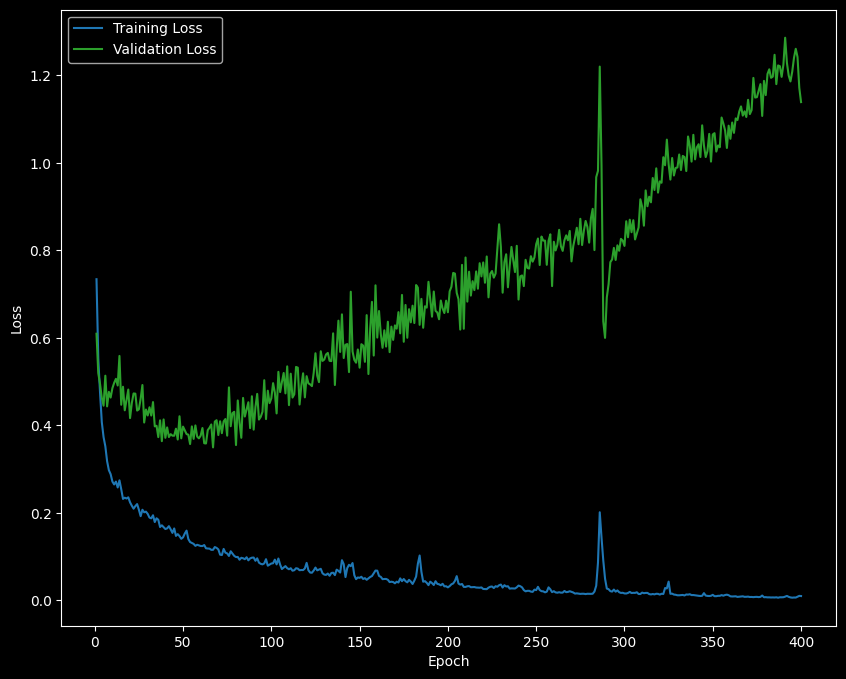

In [ ]:
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model_1()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# Let's train
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 normalization_1 (Normaliza  (None, 49, 1)             99        
 tion)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 47, 32)            128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 23, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 19, 64)            10304     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 9, 64)             0   

13/13 [==============================] - 4s 33ms/step - loss: 0.7493 - val_loss: 0.6384
Epoch 2/400
13/13 [==============================] - ETA: 0s - loss: 0.5976

13/13 [==============================] - 0s 13ms/step - loss: 0.5976 - val_loss: 0.5656
Epoch 3/400
 8/13 [=================>............] - ETA: 0s - loss: 0.5345

13/13 [==============================] - 0s 13ms/step - loss: 0.5358 - val_loss: 0.5365
Epoch 4/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.5038

13/13 [==============================] - 0s 12ms/step - loss: 0.4846 - val_loss: 0.4854
Epoch 5/400
 8/13 [=================>............] - ETA: 0s - loss: 0.4416

13/13 [==============================] - 0s 12ms/step - loss: 0.4289 - val_loss: 0.4593
Epoch 6/400
 8/13 [=================>............] - ETA: 0s - loss: 0.4031

13/13 [==============================] - 0s 12ms/step - loss: 0.3800 - val_loss: 0.4482
Epoch 7/400
 8/13 [=================>............] - ETA: 0s - loss: 0.3437

13/13 [==============================] - 0s 12ms/step - loss: 0.3563 - val_loss: 0.4916
Epoch 8/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.3104

13/13 [==============================] - 0s 13ms/step - loss: 0.3254 - val_loss: 0.4451
Epoch 9/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2791

13/13 [==============================] - 0s 13ms/step - loss: 0.3018 - val_loss: 0.4147
Epoch 10/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2709

13/13 [==============================] - 0s 13ms/step - loss: 0.2846 - val_loss: 0.4272
Epoch 11/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2786

13/13 [==============================] - 0s 12ms/step - loss: 0.2769 - val_loss: 0.4477
Epoch 12/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2802

13/13 [==============================] - 0s 12ms/step - loss: 0.2688 - val_loss: 0.4181
Epoch 13/400
13/13 [==============================] - ETA: 0s - loss: 0.2570

13/13 [==============================] - 0s 14ms/step - loss: 0.2570 - val_loss: 0.4277
Epoch 14/400
13/13 [==============================] - ETA: 0s - loss: 0.2523

13/13 [==============================] - 0s 14ms/step - loss: 0.2523 - val_loss: 0.4360
Epoch 15/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2514

13/13 [==============================] - 0s 12ms/step - loss: 0.2456 - val_loss: 0.4223
Epoch 16/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2519

13/13 [==============================] - 0s 12ms/step - loss: 0.2401 - val_loss: 0.4039
Epoch 17/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2374

13/13 [==============================] - 0s 13ms/step - loss: 0.2419 - val_loss: 0.4155
Epoch 18/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2422

13/13 [==============================] - 0s 13ms/step - loss: 0.2272 - val_loss: 0.4320
Epoch 19/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2162

13/13 [==============================] - 0s 12ms/step - loss: 0.2207 - val_loss: 0.4261
Epoch 20/400
 8/13 [=================>............] - ETA: 0s - loss: 0.1978

13/13 [==============================] - 0s 13ms/step - loss: 0.2146 - val_loss: 0.4317
Epoch 21/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2377

13/13 [==============================] - 0s 12ms/step - loss: 0.2240 - val_loss: 0.4461
Epoch 22/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2481

13/13 [==============================] - 0s 12ms/step - loss: 0.2251 - val_loss: 0.4374
Epoch 23/400
13/13 [==============================] - ETA: 0s - loss: 0.2150

13/13 [==============================] - 0s 13ms/step - loss: 0.2150 - val_loss: 0.4136
Epoch 24/400
 8/13 [=================>............] - ETA: 0s - loss: 0.2230

13/13 [==============================] - 0s 12ms/step - loss: 0.2102 - val_loss: 0.4746
Epoch 25/400
13/13 [==============================] - ETA: 0s - loss: 0.2106

13/13 [==============================] - 0s 13ms/step - loss: 0.2106 - val_loss: 0.4353
Epoch 26/400
 7/13 [===============>..............] - ETA: 0s - loss: 0.2164

13/13 [==============================] - 0s 12ms/step - loss: 0.2144 - val_loss: 0.4204


In [ ]:
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]


9/9 [==============================] - 0s 3ms/step


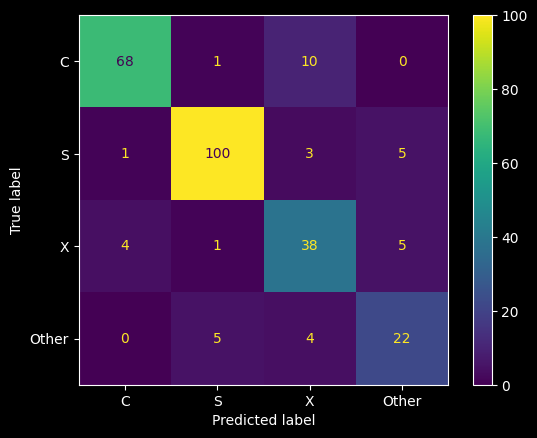

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [ ]:
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test,
                                          asteroid_classes_test_pred,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.856
